In [57]:
import numpy as np
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import json

In [2]:
with open('saved_content/procced_texts_full_vocab.txt') as fh:
    tokens = [text.strip().split() for text in fh.readlines()]

In [3]:
with open('saved_content/metadata.json') as fh:
    meta = json.load(fh)
target = meta['codes']

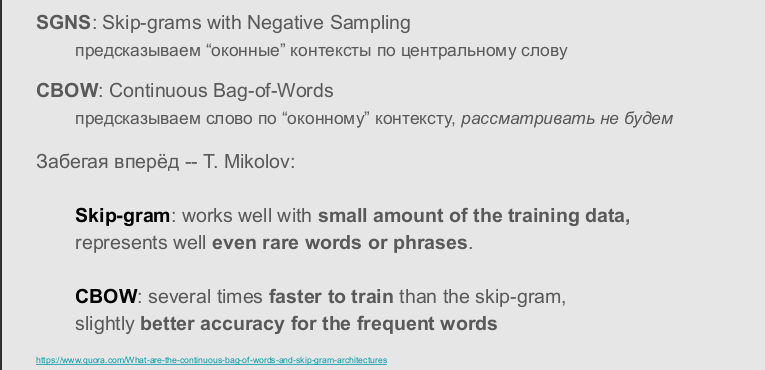

In [4]:
%%time

model_w2v = Word2Vec(
    vector_size=100,
    window=5, 
    min_count=1,
    sg=0,
    workers=1,
    seed=42
)

model_w2v.epochs = 10
model_w2v.build_vocab(tokens)

model_w2v.train(tokens,
                total_examples=model_w2v.corpus_count,
                epochs=model_w2v.epochs)

CPU times: user 8.7 s, sys: 14.5 ms, total: 8.71 s
Wall time: 8.55 s


(4862072, 5123750)

### Подготовка эмбеддингов предложений

In [5]:
docs_embeddings = []

create_mean_sent_emb = lambda lst: np.mean(np.array(lst), axis=0)#.reshape(1, -1)

for doc in tokens:
    word_embs = [model_w2v.wv[token] for token in doc]
    doc_emb = create_mean_sent_emb(word_embs)
    docs_embeddings.append(doc_emb)

### Классификаця

##### Распределение таргета

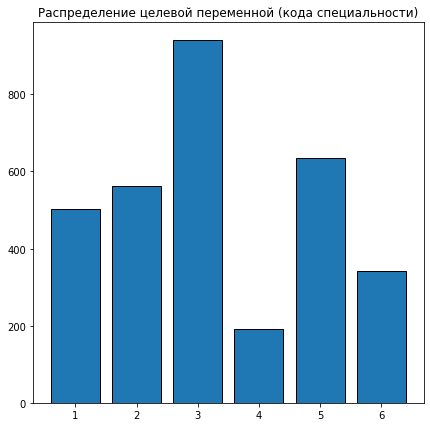

In [56]:
flatten = lambda lst_of_lsts: [elem for lst in lst_of_lsts for elem in lst]
flattened_target = flatten(target)

from collections import Counter
x = list(zip(*sorted([(k, v) for k, v in dict(Counter(flattened_target)).items()])))
fig, ax = plt.subplots(figsize=(7,7))
ax.bar(x=x[0], height=x[1], edgecolor='k')
ax.set_title('Распределение целевой переменной (кода специальности)')
;

plt.savefig('images/code_distribution.png')

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
encoded_target = mlb.fit_transform(target)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer, jaccard_score


In [43]:
lr = LogisticRegression(random_state=42,
                        n_jobs=-1,
                        C=0.1)

clf = OneVsRestClassifier(lr)

In [53]:
jac_scorer = make_scorer(jaccard_score, average='weighted')
jac_scorer

make_scorer(jaccard_score, average=weighted)

### Кросс-валидация

Метрика Жаккарда

In [54]:
mean_jaccard = np.mean(cross_val_score(clf, docs_embeddings, encoded_target, cv=5, scoring=jac_scorer))
print(f'Jaccard score: {mean_jaccard:.3f}')

Jaccard score: 0.551


### Проверка на полном наборе данных

Метрика Жаккарда

In [ ]:
# clf.fit(docs_embeddings, encoded_target)

In [55]:
# preds = clf.predict(docs_embeddings)

# jac_lr = jaccard_score(encoded_target, preds, average='weighted')

# print(f'Jaccard score: {jac_lr:.3f}')